## Monte Carlo Calculation of Harmonic Oscillator Two Point Function of $\hat{X}^3(t)$

Same as the last exercise with operators $\hat{X}^3(t)$ instead of $\hat{X}(t)$

### Potentials

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import vegas
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

#Harmonic
def v_sho(x):
    
    return (x**2)/2

#Anharmonic
def v_aho(x):
    
    return (x ** 4)/2


### Action for One Spatial Point

In [26]:
def action(x, i, v, m, a): 
    ir = (i+1)%len(x) 
    il = (i-1)%len(x)
    return a *  v(x[i]) + (m/a) * x[i] * (x[i]-x[ir]-x[il])

### Update Function

In [27]:
def update(x, v, m, a, dx):
    #Updates Every Point Once
    accept = 0
    for i in range(len(x)):
        
        x_old = x[i]
        old_action = action(x=x, i=i, v=v, m=m, a=a)
        
        x[i] += np.random.uniform(-dx, dx)
        new_action = action(x=x, i=i, v=v, m=m, a=a)
        
        diff = old_action - new_action
        
        r = np.minimum(1.0, np.exp(diff))
    
        if r < np.random.rand():
            x[i] = x_old
        
        else:
            accept += 1
    
    return x, accept / len(x)

### Two Point Function

In [28]:
def G(x):
    #Returns Array Gn = [G1, G2,...]
    n = len(x)
    g = np.zeros(n)
    for j in range(n):
        for i in range(n):
            g[j] += ((x[(i+j)%(n)])**3) * ((x[i])**3)
            
    return g/n

### Markov Chain Generation

In [29]:
def markov_chain(n_sites, n_configs, v, m, a, dx, n_corr):
    
    acc = 0
    config = np.zeros((n_sites))
    gn = []
    
    #Thermalise
    for i in range(10*n_corr):
        config = update(config, v, m, a, dx)[0]


    for i in range(n_configs*n_corr):
        config, acceptance = update(config, v, m, a, dx)
        acc += acceptance
        
        if i % n_corr == 0:
            gn.append(G(config))
            
    acc = acc / (n_configs*n_corr)
            
    return gn, acc

### Analysis

In [30]:
def analysis(n_sites, n_cfs_arr, v, m, a, dx, n_corr, harmonic=True):
    
    rows = int(np.ceil(len(n_cfs_arr)/2))
    fig, axs =  plt.subplots(nrows=rows, ncols=rows, sharex='col', figsize=(8, 8), dpi=100)
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    ax = axs.flat
    
    for i, n_configs in enumerate(n_cfs_arr):
    
        gn, acc = markov_chain(n_sites=n_sites, n_configs=n_configs, v=v, m=m, a=a, dx=dx, n_corr=n_corr)
        
        avg = np.mean(gn,0)
        err = np.std(gn,0) / np.sqrt(n_configs)
        avg_shift = np.roll(avg, -1)
        
    
        t = np.arange(0, n_sites * a, a)
        E_eff = np.log(np.divide(avg,avg_shift)) / a
    
        
        ax[i].set_xlim(0, 4)
        ax[i].set_ylim(0, 2)
        ax[i].errorbar(t, E_eff, yerr=err, fmt='o',  markersize=2, color='k')
        ax[i].tick_params(bottom="off", top="off", left="off", right="off")
        ax[i].set_title("Effective Energy for N_configs: " + str(n_configs))
        ax[i].set_xticks([0, 2, 4])
        if harmonic == True:
            ax[i].axhline(y=1, color='r', linestyle='-')
            ax[i].set_yticks([1, 2])
        elif harmonic == False:
            ax[i].set_yticks([0.5, 1, 1.5, 2])
            
        
    
    print("Acceptance Rate: " + str(acc))
    plt.show()

### Results for Harmonic Oscillator

Acceptance Rate: 0.49664024999999534


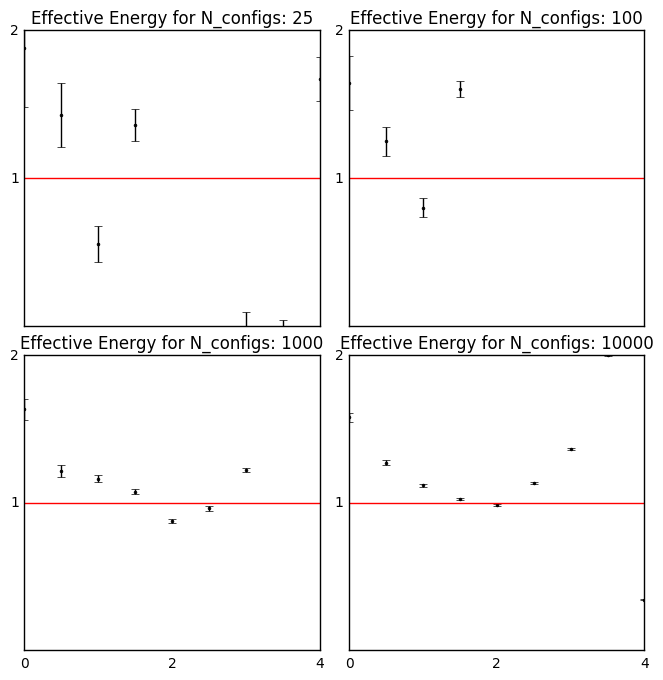

In [31]:
analysis(n_sites=20, n_cfs_arr=[25,100,1000,10000], v=v_sho, m=1, a=0.5, dx=1.4, n_corr=20)

### Results for Anharmonic Oscillator

Acceptance Rate: 0.48476074999999125


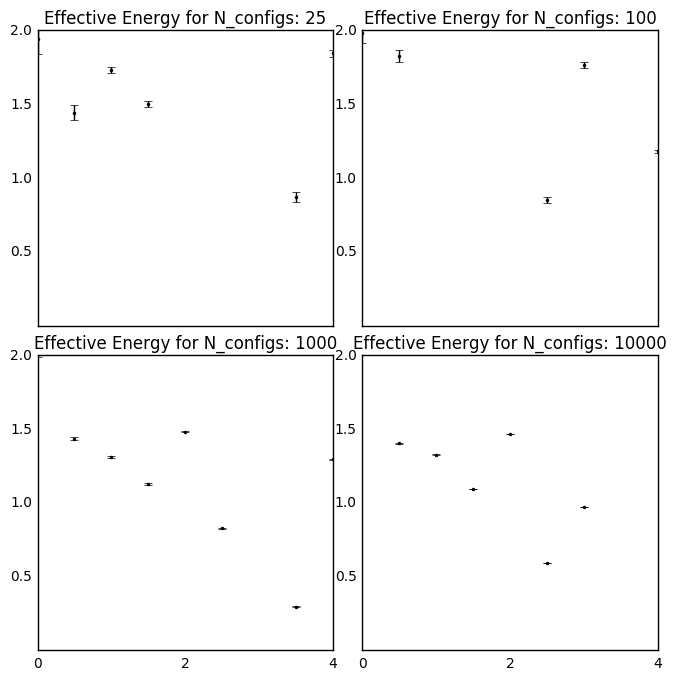

In [32]:
analysis(n_sites=20, n_cfs_arr=[25, 100, 1000, 10000], v=v_aho, m=1, a=0.5, dx=1.4, n_corr=20, harmonic=False)